lighter model for skin classification 

## 0. Data Preprocessing

In [1]:
import os
import re
import glob
import random
import warnings

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, classification_report

from tqdm.auto import tqdm

warnings.filterwarnings(action='ignore')

## 1. Load the dataset

In [2]:
df_forehead = pd.read_csv("new_df_forehead.csv", index_col = 0)

# NaN 값을 0이나 다른 값으로 채운 후 변환
df_forehead['forehead_wrinkle'] = df_forehead['forehead_wrinkle'].fillna(0).astype(int)

# NaN을 유지하면서 변환 (nullable Int64 type)
df_forehead['forehead_wrinkle'] = df_forehead['forehead_wrinkle'].astype('Int64')

# NaN 값을 0이나 다른 값으로 채운 후 변환
df_forehead['adj_forehead_wrinkle_2'] = df_forehead['adj_forehead_wrinkle_2'].fillna(0).astype(int)

# NaN을 유지하면서 변환 (nullable Int64 type)
df_forehead['adj_forehead_wrinkle_2'] = df_forehead['adj_forehead_wrinkle_2'].astype('Int64')


# df_forehead['image_name'] = df_forehead['image_name'].apply(lambda x: "_".join(x.split('_')[0:3]) + '.jpg')

df_forehead

,id,gender,age,angle,width,height,facepart,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max,forehead_wrinkle,partname,image_name,label_name,adj_forehead_wrinkle,adj_forehead_wrinkle_2
1,1,F,55,F,2136,3216,1,469.0,661.0,1638.0,1197.0,3,이마,0001_01_F.jpg,0001_01_F_01.json,1.0,1
10,1,F,55,L15,2136,3216,1,369.0,595.0,1540.0,1176.0,3,이마,0001_01_L15.jpg,0001_01_L15_01.json,1.0,1
19,1,F,55,L30,2136,3216,1,404.0,561.0,1427.0,1159.0,3,이마,0001_01_L30.jpg,0001_01_L30_01.json,1.0,1
28,1,F,55,R15,2136,3216,1,494.0,573.0,1772.0,1131.0,3,이마,0001_01_R15.jpg,0001_01_R15_01.json,1.0,1
37,1,F,55,R30,2136,3216,1,744.0,577.0,1755.0,1175.0,3,이마,0001_01_R30.jpg,0001_01_R30_01.json,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43381,1100,F,28,F,2136,3216,1,504.0,879.0,1629.0,1248.0,1,이마,1100_01_F.jpg,1100_01_F_01.json,0.0,0
43390,1100,F,28,L15,2136,3216,1,339.0,847.0,1400.0,1201.0,1,이마,1100_01_L15.jpg,1100_01_L15_01.json,0.0,0
43399,1100,F,28,L30,2136,3216,1,327.0,843.0,1261.0,1193.0,1,이마,1100_01_L30.jpg,1100_01_L30_01.json,0.0,0
43408,1100,F,28,R15,2136,3216,1,671.0,833.0,1764.0,1209.0,1,이마,1100_01_R15.jpg,1100_01_R15_01.json,0.0,0


## 2. Check the balance between the classes in the target

In [7]:
# original label
print(df_forehead['forehead_wrinkle'].unique())

#label rebalancing
print(df_forehead['adj_forehead_wrinkle_2'].unique()) ### 그래프로 하면 더 좋았겠음

class_counts = df_forehead['adj_forehead_wrinkle_2'].value_counts(sort=False).to_dict()
num_samples = sum(class_counts.values())
class_weights = {l: round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

#print(f'cls_cnts: {len(class_counts)}\n num_samples:{num_samples}')

labels =  df_forehead['adj_forehead_wrinkle_2'].to_list()
weights = [class_weights[labels[i]] for i in range(int(num_samples))] 
sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

print('class weight for each label :' , class_weights)

<IntegerArray>
[3, 1, 0, 2, 4, 5, 6]
Length: 7, dtype: Int64
<IntegerArray>
[1, 0, 2, 3]
Length: 4, dtype: Int64
class weight for each label : {1: 2.46, 0: 2.46, 2: 12.7, 3: 9.28}


## 3. Image resizing

In [8]:
import cv2
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        """
        Args:
        - df: DataFrame containing image paths, labels, and bounding box coordinates.
        - transforms: Any transformations to be applied to the images.
        """
        self.df = df
        self.df['path'] = '/Users/jaeeunlee/Documents/ds_study/ds_study/deeplearning project/4. skin_digital/dataset/img/'+ df_forehead['image_name']
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Fetch the row corresponding to this index
        row = self.df.iloc[index]
        
        # Extract image path and bounding box coordinates from the row
        img_path = row['path']
        bbox_x_min = int(row['bbox_x_min'])
        bbox_y_min = int(row['bbox_y_min'])
        bbox_x_max = int(row['bbox_x_max'])
        bbox_y_max = int(row['bbox_y_max'])

        # Read and crop the image using cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Crop the image using the bounding box coordinates
        cropped_image = image[bbox_y_min:bbox_y_max, bbox_x_min:bbox_x_max]
        
        # Apply any transformations if they are provided
        if self.transforms is not None:
            cropped_image = self.transforms(cropped_image)  # 이미지 자체를 전달
        
        # If the label is available, return the cropped image and the label
        if 'forehead_wrinkle' in row:
            label = row['adj_forehead_wrinkle_2']
            return cropped_image, label
        else:
            return cropped_image
        
    def __len__(self):
        return len(self.df)

## Training and Validation Sets

In [22]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Example transformations (you can modify as needed)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.5)
])

# Create the dataset
dataset = CustomDataset(df=df_forehead, transforms=data_transforms)  # --> transform 나중에 해도 되는거 아닌가..? 그래야 보여줄 수 있을 거 같은뎅.....

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Example of how to get an image and label
cropped_image, label = dataset[0]

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader)) #4825 * 0.8 / 32 = 121
print(len(val_loader)) #4825 * 0.2 / 32 = 31

#첫 한세트 테스트 하기 
for images, labels in train_loader :
    break

print(images.shape) #1계 텐서 변환 전(변환 ㅅ)
print(labels.shape)

91
31
torch.Size([32, 3, 224, 224])
torch.Size([32])


## 4. Movilenet V2: Dropout, Batchsize, 

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
import json
import glob
import os
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)

#난수 고정
#torch_seed()

#최종 레이어 함수의 교체 
#이 모델은 원래 1000 종류의 클래스를 분류하는 모델 > 출력 차원 변경하기
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True), #중간층 노드 수 256으로 설정 
    nn.Dropout(p=0.5),
    nn.Linear(256, 32), #출력 직전 은닉층 노드 수를 32로 줄임
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.8), #추가적인 Dropout
    nn.Linear(32, 4) #최종 출력층 (클래스 수 4으로 설정)
    )

# GPU사용
model = model.to(device)
# 모델 구조 및 파라미터 요약
print("Model Summary:")
summary(model, (3, 224, 224))


# 손실 함수
weights = torch.tensor([2.46, 2.46, 12.7, 9.28]) #이마 class_weight
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')

# 옵티마이저, lr 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #Regulization


# 학습 루프
num_epochs = 1 # 에폭 수를 10으로 설정

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14    

## 4-1. Training the revised model

In [24]:
#fit 함수 만들어보기 
# 학습용 함수
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def fit(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    #출력값 저장
    all_preds = []
    all_labels = []
  
    for epoch in range(base_epochs, num_epochs + base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        model.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

        scheduler.step() #매 에폭마다 learning rage를 조정

        # 손실과 정확도 계산
        avg_train_loss = train_loss / count
        avg_train_acc = train_acc / count

        # 예측 페이즈
        model.eval()
        count = 0

        for inputs, labels in val_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 예측과 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

        # 손실과 정확도 계산
        avg_val_loss = val_loss / count
        avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
        
    return history, all_preds, all_labels

## 4-2. Validation

In [25]:
from sklearn.metrics import classification_report

history = np.zeros((0,5))
history, all_preds, all_labels = fit(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, history)

# classification report 출력
print(classification_report(all_labels, all_preds))

  0%|          | 0/91 [00:00<?, ?it/s]

Epoch [1/1], loss: 0.04001 acc: 0.37133 val_loss: 0.03068, val_acc: 0.57409
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       398
           1       0.59      0.36      0.45       378
           2       0.23      0.04      0.07        73
           3       0.35      1.00      0.51       116

    accuracy                           0.57       965
   macro avg       0.49      0.54      0.45       965
weighted avg       0.61      0.57      0.56       965



## 4-3. Test

In [ ]:
def evaluate_testset(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs, 1)[1]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item()
            test_acc += (predicted == labels).sum().item()
            total += len(labels)

    avg_test_loss = test_loss / total
    avg_test_acc = test_acc / total

    print(f'Test loss: {avg_test_loss:.5f}, Test accuracy: {avg_test_acc:.5f}')
    return avg_test_loss, avg_test_acc, all_preds, all_labels


In [28]:
history = np.zeros((0,5))
_, _, all_preds, all_labels = evaluate_testset(model, test_loader, criterion, device)

# classification report 출력
print(classification_report(all_labels, all_preds))

Test loss: 0.03129, Test accuracy: 0.58860
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       383
           1       0.67      0.39      0.49       394
           2       0.33      0.02      0.05        82
           3       0.32      1.00      0.49       106

    accuracy                           0.59       965
   macro avg       0.52      0.55      0.45       965
weighted avg       0.64      0.59      0.57       965



In [29]:
# ConfusionMatrix 출력을 위한 함수
def draw_confusion_matrix3(all_preds, all_labels):
    cm = confusion_matrix(all_labels, all_preds)

    # 시각화
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', cbar=False, xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
    plt.ylabel('Actual Lablel', fontsize = 13)
    plt.xlabel('Predicted Label' ,  fontsize = 13)
    plt.title('Confusion Matrix',  fontsize= 20)
    plt.show()

In [30]:
import random
import matplotlib.pyplot as plt
import numpy as np
from koreanize_matplotlib import koreanize

def visualize_predictions(val_loader, device, all_preds, all_labels, num_image=16):
    # val_loader에서 이미지 가져오기
    val_images = []
    val_true_labels = []

    for images, labels in val_loader:
        val_images.append(images.cpu())
        val_true_labels.append(labels.cpu())

    # 하나의 텐서로 결합
    val_images = torch.cat(val_images, dim=0)
    val_true_labels = torch.cat(val_true_labels, dim=0)

    # 이미지, 예측 라벨, 실제 라벨에서 랜덤으로 num_images 선택
    random_indices = random.sample(range(len(val_images)), num_image)
    random_images = val_images[random_indices]
    random_true_labels = val_true_labels[random_indices]
    random_preds = np.array(all_preds)[random_indices]

    # 4*4로 시각화
    fig, axs = plt.subplots(4, 4, figsize=(16, 16), dpi=100)
    axs = axs.flatten()

    for i in range(num_image):
        img = random_images[i].permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]) #역정규화
        img = np.clip(img, 0, 1) #0-1 범위로 클리핑

        # 이미지 표시
        axs[i].imshow(img, interpolation='none')
        axs[i].set_title(f'예측: {random_preds[i]}, 실제: {random_true_labels[i]}')
        axs[i].axis('off') # 축 제거

    plt.tight_layout()
    plt.show()

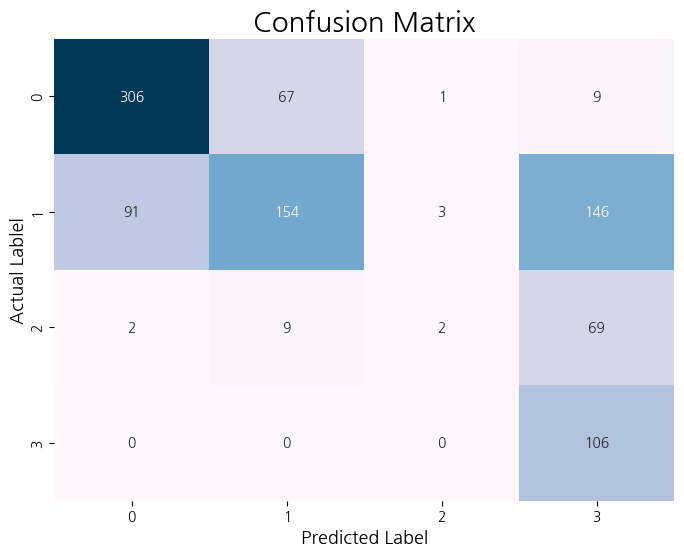

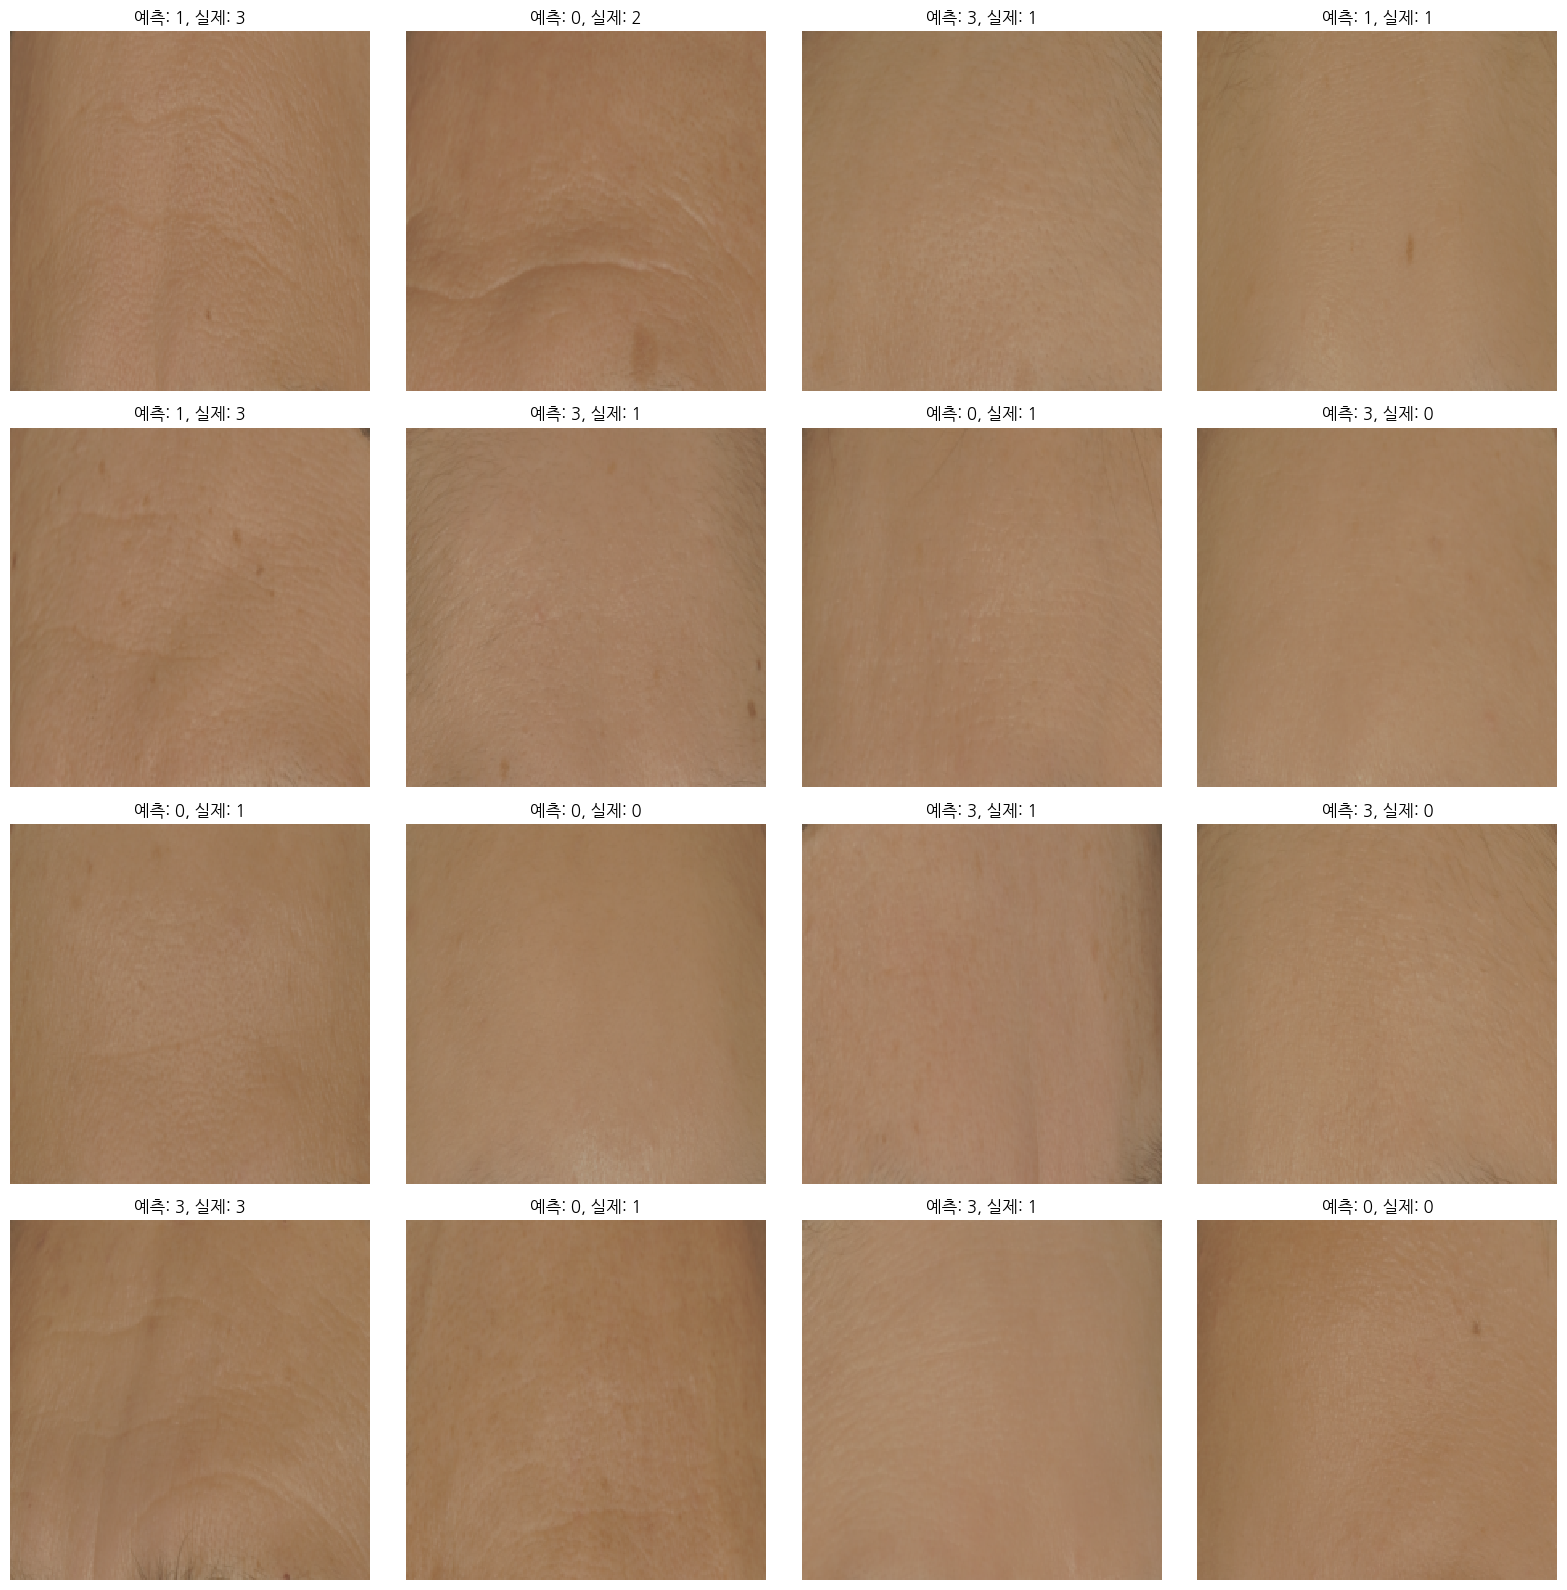

In [31]:
#evaluate_history4(history)
draw_confusion_matrix3(all_preds, all_labels)
visualize_predictions(val_loader, device, all_preds, all_labels)

## 5. Image augmentation Check(???) -> 순서...

In [32]:
# Define different transforms for train and test sets
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),    # RandomVerticalFlip 사용
    transforms.RandomRotation(degrees=15)
    ])

    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ### -> 

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.5)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(0.5, 0.5)
])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## 6. Squeezenet : 이름을 다르게 해서 하는 거 같음!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the SqueezeNet model with pretrained weights
model = models.squeezenet1_0(pretrained=True)

#난수 고정
#torch_seed()

# 마지막 레이어 교체
num_classes = 4  # 분류할 클래스 수


model.classifier = nn.Sequential(
    nn.Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1)),  # 첫 번째 은닉층
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Conv2d(32, num_classes, kernel_size=(1, 1), stride=(1, 1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)) # 최종 출력 레이어
)

# GPU사용
model = model.to(device)

# 모델 구조 및 파라미터 요약
print("Model Summary:")
summary(model, (3, 224, 224))


#손실함수
weights = torch.tensor([2.46, 2.46, 12.7, 9.28]) #이마 class_weight
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')

# 옵티마이저, lr 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #Regulization


# 학습 루프
num_epochs = 50

In [ ]:
#history 초기화
history = np.zeros((0,5))
history, all_preds, all_labels = fit(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, history)

In [ ]:
draw_confusion_matrix3(all_preds, all_labels)
visualize_predictions(val_loader, device, all_preds, all_labels)